# Librerias

In [79]:
#Importemos las librerías Necesarias:
import scipy as sc
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random, time

In [80]:
from sklearn.model_selection import *
from sklearn.feature_selection import *
from sklearn.linear_model import *
from sklearn.preprocessing import *
from sklearn.metrics import *
from sklearn.tree import *
from sklearn.neighbors import *
from sklearn.ensemble import *

***

# Main Code

**Empecemos por cargar la infromacion:**

lr --> Todo aquello relacionado con el modelo y el df para la regresión lineal.<br>
c --> Todo aquello relacionado con el modelo y el df empleado para la clasificación.

## Clasificación

In [81]:
c_cols = ['pelvic_incidence', 'pelvic_tilt', 'lumbar_lordosis_angle', 'sacral_slope', 'pelvic_radius', 'degree_spondylolisthesis', 'class']
c_df = pd.read_csv('Data/column_3C.dat', sep=' ', names=c_cols)

In [82]:
# veamos que pinta tiene el df:
c_df.head()

,pelvic_incidence,pelvic_tilt,lumbar_lordosis_angle,sacral_slope,pelvic_radius,degree_spondylolisthesis,class
0,63.03,22.55,39.61,40.48,98.67,-0.25,DH
1,39.06,10.06,25.02,29.00,114.41,4.56,DH
2,68.83,22.22,50.09,46.61,105.99,-3.53,DH
3,69.30,24.65,44.31,44.64,101.87,11.21,DH
4,49.71,9.65,28.32,40.06,108.17,7.92,DH


De entrada vemos que los datos no están en la misma escala por lo que convendría escalarlos. <br>
Por otra parte vemos que todas las variables son numéricas por lo que no es necesario trabajar ese aspecto.<br>
Además, dada la reducida dimensionalidad del problema, no es preciso reducirla.

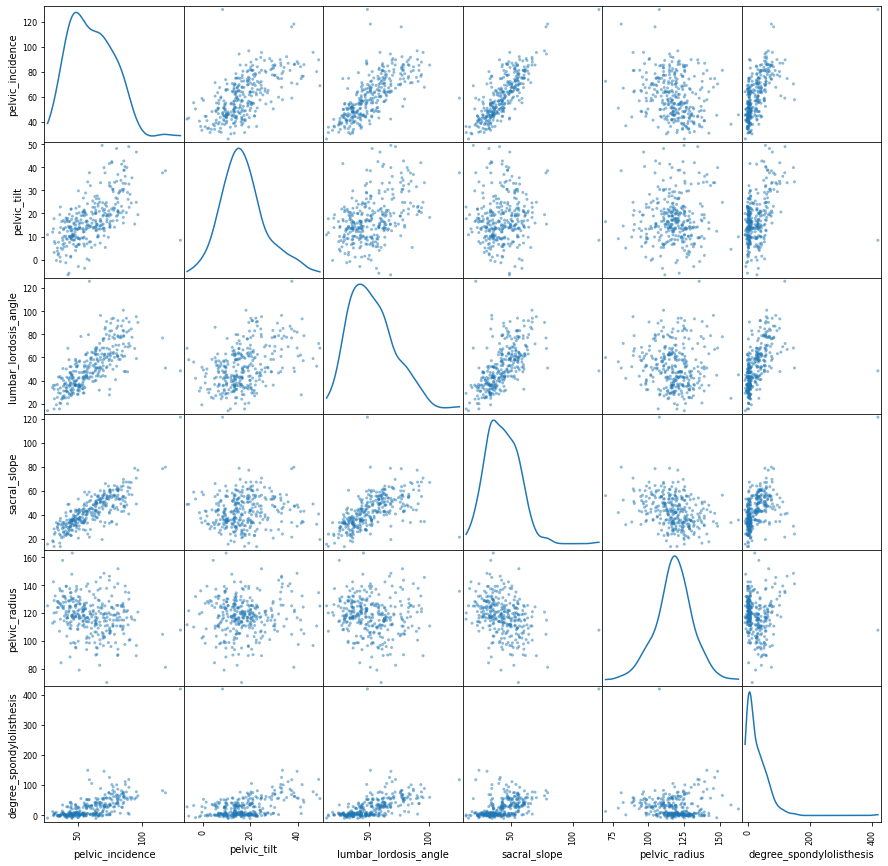

In [83]:
# Antes de escalar los datos veamos si existen Outliers:
matrix = pd.plotting.scatter_matrix(c_df, alpha=0.5, figsize=(15, 15), diagonal='kde')

Dado que en todas las variables hay outliers, emplearemos el robust scaller:

In [84]:
# Adecuemos el DF
scl_df = c_df.drop(c_cols[-1], axis=1)

# Creamos el objeto y transformamos los datos:
scl_model = RobustScaler()
scl_model.fit(scl_df)
scl_df = scl_model.transform(scl_df)

# Adecuamos los datos 
scl_df = pd.DataFrame(scl_df, columns=c_cols[:-1])
c_df = pd.concat((scl_df, c_df[c_cols[-1]]), axis=1)
c_df.head()

,pelvic_incidence,pelvic_tilt,lumbar_lordosis_angle,sacral_slope,pelvic_radius,degree_spondylolisthesis,class
0,0.164099,0.540493,-0.382885,-0.099509,-1.327799,-0.302759,DH
1,-0.742225,-0.550098,-0.944038,-0.692944,-0.261223,-0.181555,DH
2,0.383401,0.511679,0.020192,0.217369,-0.831780,-0.385410,DH
3,0.401172,0.723859,-0.202115,0.115534,-1.110961,-0.013985,DH
4,-0.339541,-0.585898,-0.817115,-0.121220,-0.684059,-0.096888,DH


In [85]:
# preparemos la información:
X_train, X_test, y_train, y_test = train_test_split(
    c_df.drop(c_cols[-1], axis=1),
    c_df[c_cols[-1]],
    test_size=0.4,
    random_state=random.seed(time.time()) 
)

Emplearemos el Decision Tree Classifier pero en esta ocasión, nos evitaremos los procesos de optimización:

In [86]:
c_model = DecisionTreeClassifier()
c_model.fit(X_train, y_train)
c_y_pred = c_model.predict(X_test)

Balanced Accuracy Score: 0.7751612308826239  Accuracy Score: 0.8306451612903226


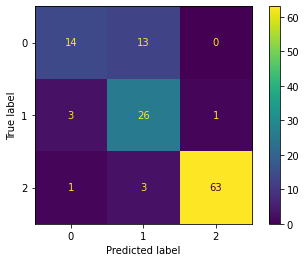

In [87]:
# veamos los resultados:
c_bacc = balanced_accuracy_score(c_y_pred, y_test)
c_acc = accuracy_score(c_y_pred, y_test)
print(f'Balanced Accuracy Score: {c_bacc}  Accuracy Score: {c_acc}')
m = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(c_y_pred, y_test)).plot()

**Empleemos ahora modelos de Bagging**

Balanced Accuracy Score: 0.7704668165026222  Accuracy Score: 0.8387096774193549


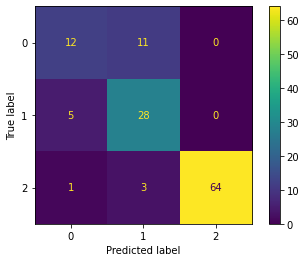

In [88]:
c_bag = BaggingClassifier(
    base_estimator=c_model,
    n_estimators=100,
    max_samples=0.5,
    random_state=random.seed(time.time())
)
c_bag.fit(X_train, y_train)
y_pred = c_bag.predict(X_test)
c_bacc = balanced_accuracy_score(y_pred, y_test)
c_acc = accuracy_score(y_pred, y_test)
print(f'Balanced Accuracy Score: {c_bacc}  Accuracy Score: {c_acc}')
m = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_pred, y_test)).plot()

Se puede apreciar una ligera mejora en los resultados.

**Probemos con modelos de Boosting**

Balanced Accuracy Score: 0.7582455378154304  Accuracy Score: 0.8225806451612904


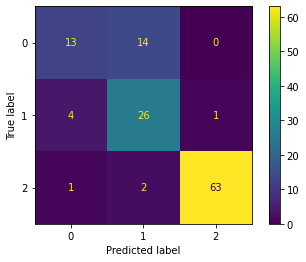

In [89]:
c_boost = AdaBoostClassifier(
    base_estimator=c_model,
    n_estimators=100,
    learning_rate=1,
    random_state=random.seed(time.time())
)
c_boost.fit(X_train, y_train)
y_pred = c_boost.predict(X_test)
c_bacc = balanced_accuracy_score(y_pred, y_test)
c_acc = accuracy_score(y_pred, y_test)
print(f'Balanced Accuracy Score: {c_bacc}  Accuracy Score: {c_acc}')
m = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_pred, y_test)).plot()

Al Emplear los modelos de Boosting, para este caso al menos, no se aprecia mejora, mas bien es al contrario por lo que podemos deducir que en este caso, lo optimo sería emplear un modelo de Bagging.

## Regresión Lineal

Empecemos por cargar la información:

In [90]:
# Empecemos por adecuar los datos:
rf = open('Data/pop_failures.csv', 'r')  # Abrimos el archivo

# Obtenemos los nombres de las columnas:
lr_cols = list()
for item in rf.readline()[:-1].split(' '):
    if item is not '':
        lr_cols.append(item)

# Limpiamos el resto de información convirtiéndola en una lista de listas
data = list()
for item in rf.readlines():
    list(item.strip().split())
    data.append(list(item.strip().split()))
    
# convertimos lo anterior en un DataFrame
lr_df = pd.DataFrame(data, columns=lr_cols)

# convirtamos la información a su tipo correspondiente:
for col in lr_cols:
    lr_df[col] = pd.to_numeric(lr_df[col])

lr_df.head()

,Study,Run,vconst_corr,vconst_2,vconst_3,vconst_4,vconst_5,vconst_7,ah_corr,ah_bolus,...,efficiency_factor,tidal_mix_max,vertical_decay_scale,convect_corr,bckgrnd_vdc1,bckgrnd_vdc_ban,bckgrnd_vdc_eq,bckgrnd_vdc_psim,Prandtl,outcome
0,1,1,0.859036,0.927825,0.252866,0.298838,0.170521,0.735936,0.428325,0.567947,...,0.245675,0.104226,0.869091,0.997518,0.448620,0.307522,0.858310,0.796997,0.869893,0
1,1,2,0.606041,0.457728,0.359448,0.306957,0.843331,0.934851,0.444572,0.828015,...,0.616870,0.975786,0.914344,0.845247,0.864152,0.346713,0.356573,0.438447,0.512256,1
2,1,3,0.997600,0.373238,0.517399,0.504993,0.618903,0.605571,0.746225,0.195928,...,0.679355,0.803413,0.643995,0.718441,0.924775,0.315371,0.250642,0.285636,0.365858,1
3,1,4,0.783408,0.104055,0.197533,0.421837,0.742056,0.490828,0.005525,0.392123,...,0.471463,0.597879,0.761659,0.362751,0.912819,0.977971,0.845921,0.699431,0.475987,1
4,1,5,0.406250,0.513199,0.061812,0.635837,0.844798,0.441502,0.191926,0.487546,...,0.551543,0.743877,0.312349,0.650223,0.522261,0.043545,0.376660,0.280098,0.132283,1


Dada la Dimension del Problema, veamos si podemos reducirla:

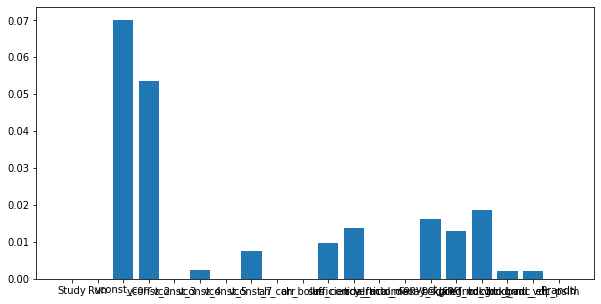

In [91]:
seed = random.seed(time.time())

X = lr_df.drop(lr_cols[-1], axis=1)
y = lr_df[lr_cols[-1]]
cls = mutual_info_classif(X, y, random_state=seed)

plt.figure(figsize=(10,5))
plt.bar(lr_cols[:-1], cls)
plt.show()

Como podemos observar, se puede reducir la dimensionalidad ya que ciertas variables no aportan a penas nada al problema.

In [92]:
# Quedemonos con las variables que realmente aportan algo:
for i in range(len(cls)):
    if cls[i] < 0.001:  # Filtramos las variables por su peso
        lr_df = lr_df.drop(lr_cols[i], axis=1)
lr_df.head()

,vconst_corr,vconst_2,vconst_4,vconst_7,slm_corr,efficiency_factor,convect_corr,bckgrnd_vdc1,bckgrnd_vdc_ban,bckgrnd_vdc_eq,bckgrnd_vdc_psim,outcome
0,0.859036,0.927825,0.298838,0.735936,0.474370,0.245675,0.997518,0.448620,0.307522,0.858310,0.796997,0
1,0.606041,0.457728,0.306957,0.934851,0.296618,0.616870,0.845247,0.864152,0.346713,0.356573,0.438447,1
2,0.997600,0.373238,0.504993,0.605571,0.815667,0.679355,0.718441,0.924775,0.315371,0.250642,0.285636,1
3,0.783408,0.104055,0.421837,0.490828,0.010015,0.471463,0.362751,0.912819,0.977971,0.845921,0.699431,1
4,0.406250,0.513199,0.635837,0.441502,0.358534,0.551543,0.650223,0.522261,0.043545,0.376660,0.280098,1


Veamos si es necesario escalar los datos:

In [93]:
lr_df.describe()

,vconst_corr,vconst_2,vconst_4,vconst_7,slm_corr,efficiency_factor,convect_corr,bckgrnd_vdc1,bckgrnd_vdc_ban,bckgrnd_vdc_eq,bckgrnd_vdc_psim,outcome
count,540.000000,540.000000,540.000000,540.000000,540.000000,540.000000,540.000000,540.000000,540.000000,540.000000,540.000000,540.000000
mean,0.500026,0.500097,0.500119,0.499913,0.500044,0.500111,0.499933,0.499944,0.499946,0.500044,0.500020,0.914815
std,0.288939,0.288922,0.288993,0.288852,0.288860,0.288966,0.288822,0.288949,0.288923,0.288813,0.288936,0.279416
min,0.000414,0.001922,0.001972,0.000476,0.003231,0.002015,0.001312,0.002509,0.000732,0.000891,0.000219,0.000000
25%,0.249650,0.251597,0.250158,0.251325,0.252661,0.250758,0.249988,0.249586,0.249974,0.250412,0.252739,1.000000
50%,0.499998,0.499595,0.500456,0.499174,0.500295,0.500393,0.500625,0.499080,0.499959,0.500384,0.498955,1.000000
75%,0.750042,0.750011,0.750348,0.748166,0.748605,0.749447,0.749569,0.750012,0.747978,0.749256,0.748539,1.000000
max,0.999194,0.998815,0.997673,0.997142,0.997172,0.999536,0.997518,0.999795,0.999155,0.997265,0.999306,1.000000


Dado que todas la variables se hallan entre 0 y 1, no será necesario realizar ningún escalado.<br>
Pasemos por tanto al modelo, emplearemos el KNRegressor.

In [94]:
# Antes de nada preparemos los datos:
X_train, X_test, y_train, y_test = train_test_split(
    lr_df.drop(lr_cols[-1], axis=1),
    lr_df[lr_cols[-1]],
    test_size=0.4,
    random_state=random.seed(time.time()) 
)

In [95]:
#Establezcamos el modelo:
lr_model = KNeighborsRegressor()

In [96]:
lr_model.fit(X_train, y_train)
lr_y_pred = lr_model.predict(X_test)

# veamos los resultados:
rmse = np.sqrt(mean_squared_error(lr_y_pred, y_test))

print(f'Error Cuadrático Medio: {rmse}')

Error Cuadrático Medio: 0.26770630673681683


**Pasemos a Bagging**

In [100]:
lr_bag = BaggingRegressor(
    base_estimator=lr_model,
    n_estimators=50,
    max_samples=0.5,
    random_state=random.seed(time.time())
)
lr_bag.fit(X_train, y_train)
y_pred = lr_bag.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_pred, y_test))

print(f'Error Cuadrático Medio: {rmse}')

Error Cuadrático Medio: 0.26056349194262296


Empleando el modelo de bagging para regresiones lineales vemos una pequeña mejora en el error del modelo, probemos ahora con modelos de boosting:

In [99]:
lr_boost = AdaBoostRegressor(lr_model
    base_estimator=lr_model,
    n_estimators=5,
)
lr_boost.fit(X_train, y_train)
y_pred = lr_boost.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_pred, y_test))

print(f'Error Cuadrático Medio: {rmse}')


Error Cuadrático Medio: 0.30912061651652345


El mejor resultado con los modelos de boosting en cualquier caso ha sido menos favorable que los modelos de bagging por lo que podemos concluir que en este caso, el empleo de modelos de bagging resulta mas optimo.

***

## Notas:

> Nota 1

## Bibliografia:

   * Elemento bibliografico 1
   * Elemento bibliografico 2

### Autor

   - **Name:** Elidas
   - **Email:** pyro.elidas@gmail.com
   - **Python version:** 3.9.1
   - **Date:** ${DATE}